In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
sys.path.append('../../03b_model/src')
from LSTMDA_torch import LSTMDA, fit_torch_model, rmse_masked
import seaborn as sns
import torch
#import run_model
import yaml
import matplotlib.pyplot as plt

In [2]:
#read prepped data in
prepped_model_io_data_file = '../out/prepped_model_io_data'
with open(prepped_model_io_data_file, 'rb') as f:
    prepped_model_io_data = pickle.load(f)

In [3]:
#set parameters using config file
with open("../model_config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

#x variables
inputs = config['inputs']
#model target
target = config['target']

#other params from config file
seq_len = config['seq_len']
offset = config['offset']
n_epochs = config['n_epochs']
hidden_units = config['hidden_units']
learn_rate = config['learn_rate']
recur_dropout = config['recur_dropout']
dropout = config['dropout']

n_batch, seq_len, n_feat  = prepped_model_io_data['trainval_features'].shape

In [4]:
prepped_model_io_data['train_features'].shape

torch.Size([20, 180, 10])

In [5]:
model = LSTMDA(n_feat, hidden_units, recur_dropout, dropout)

model.load_state_dict(torch.load('../out/Run_XAI_test_01/weights.pt')) # ensure that dropout layers are active
model.eval()
x = prepped_model_io_data['trainval_features']
y_pred, _ = model(x)
y = prepped_model_io_data['trainval_targets']

In [6]:
model, y_pred.shape, x[:1].size

(LSTMDA(
   (dropout): Dropout(p=0.1, inplace=False)
   (recur_dropout): Dropout(p=0.0, inplace=False)
   (dense): Linear(in_features=10, out_features=1, bias=True)
 ),
 torch.Size([30, 180, 1]),
 <function Tensor.size>)

In [7]:
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss


def expected_gradients(x, y, x_set, model, n_samples, temporal_focus=None):
    n_series = x_set.shape[0]
    seq_len = x_set.shape[1]
    n_vars = x_set.shape[2]

    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT/YEAR
        rand_series = np.random.choice(n_series)
        baseline_x = x_set[rand_series].reshape(1,seq_len,n_vars)
        
        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y,_ = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus != None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        
        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/n_samples
            
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)
    return(expected_gradients)


loss_fn = rmse_masked

In [8]:
prepped_model_io_data.keys()

dict_keys(['train_features', 'train_targets', 'val_features', 'val_targets', 'trainval_features', 'trainval_targets', 'test_features', 'test_targets', 'means_stds'])

In [9]:
np.argwhere(y.detach().numpy() == np.nanmax(y.detach().numpy()))

array([[ 3, 93,  0]])

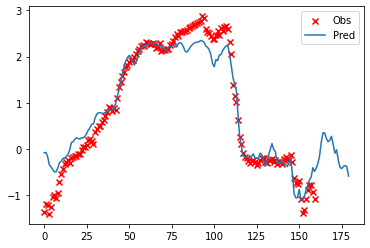

In [11]:
plt.scatter(range(180), y[3, :, 0].detach(), color = 'red', marker = 'x', label = "Obs")
plt.plot(y_pred[3, :,0].detach(), label = 'Pred')
plt.legend();

In [50]:
optimal_input = x.clone()
optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)
loss_fn = rmse_masked
loss_ls = []
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data

m = torch.nn.ReLU()

for i in range(25):
    
    optimal_output,_ = model(optimal_input)
    loss = loss_fn(y[3,:,:], optimal_output[3, :,:]) #+ m(torch.negative((optimal_input[:,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean)))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

RuntimeError: grad can be implicitly created only for scalar outputs

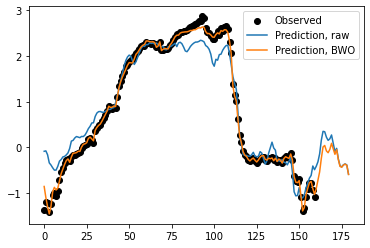

In [13]:
plt.scatter(range(180), y[3].detach(), color = 'black', label = 'Observed')

natural_out, _ = model(x)
plt.plot(natural_out[3].detach(), label = 'Prediction, raw')

optimal_out, _ = model(optimal_input)
plt.plot(optimal_output[3].detach(), label = 'Prediction, BWO')
plt.legend(loc = 'upper right');

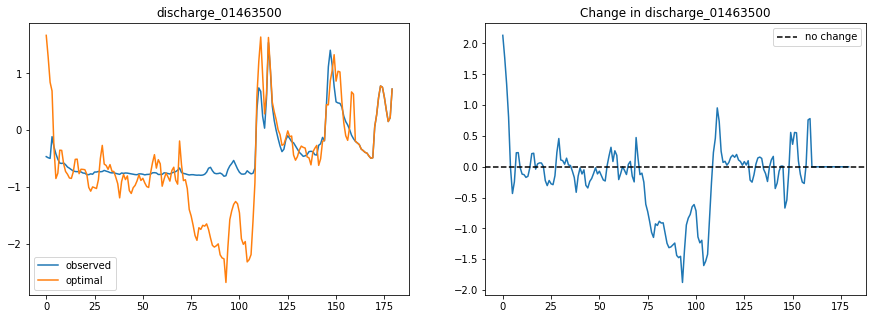

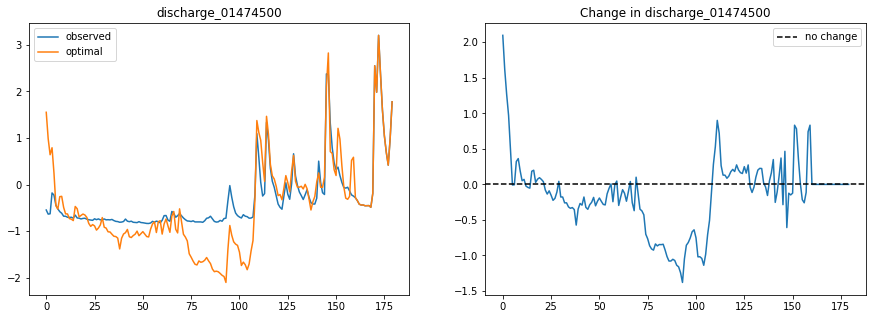

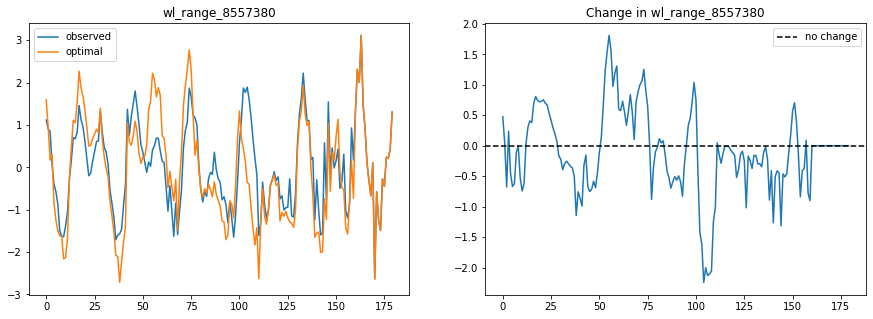

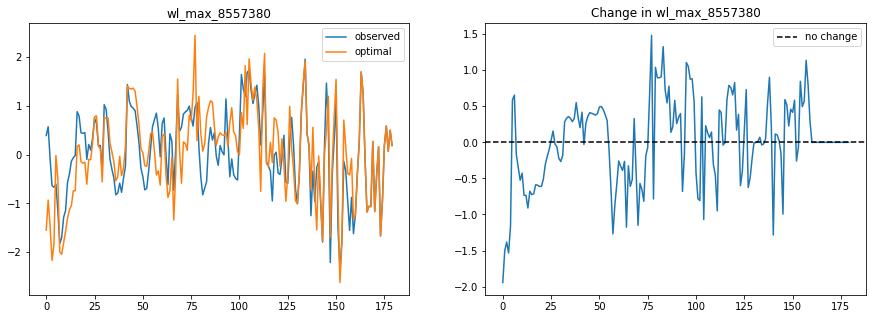

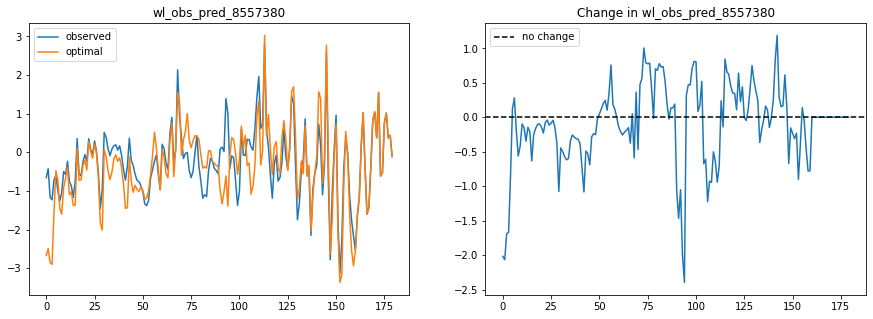

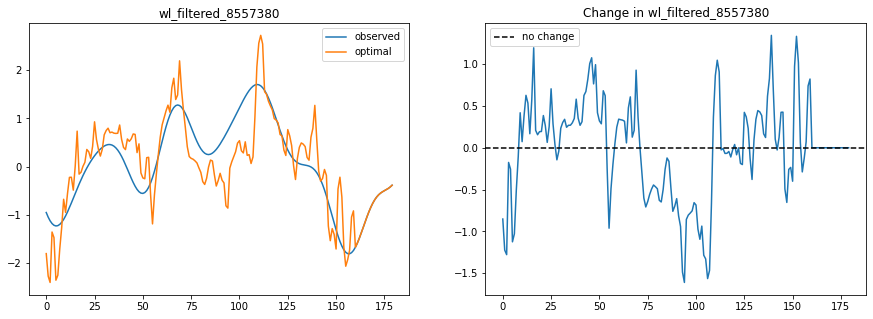

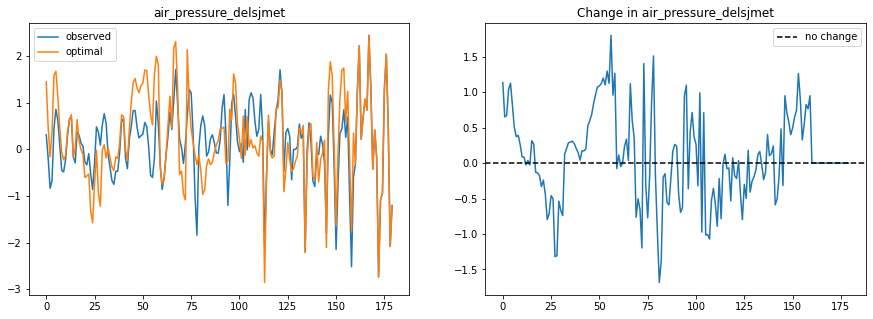

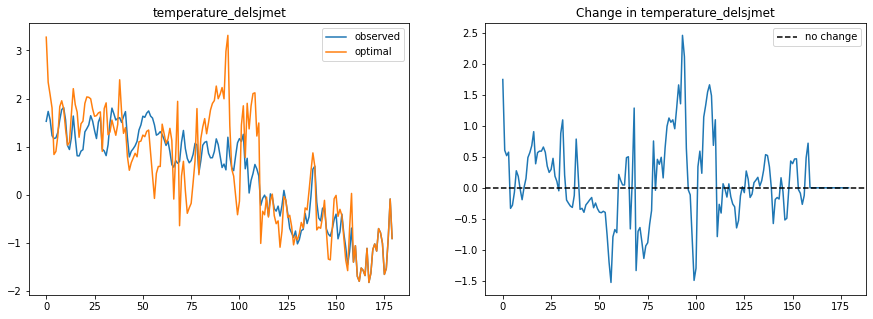

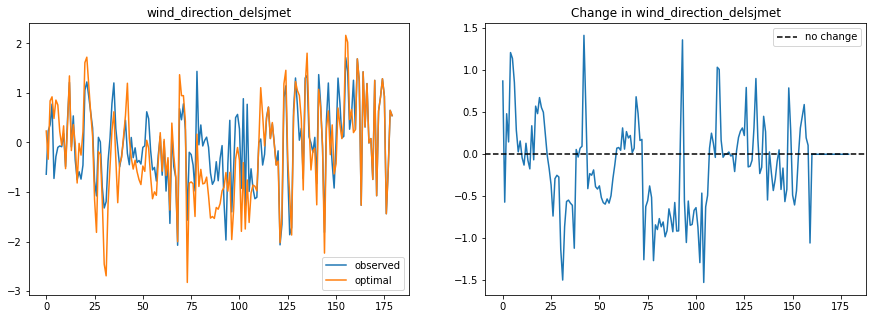

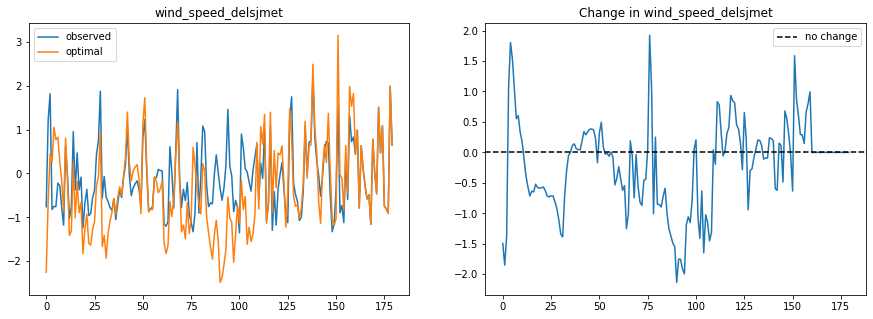

In [14]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(range(180), x[3, :, i].detach(), label = 'observed')
    ax[0].plot(range(180), optimal_input[3, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(inputs[i])
    
    ax[1].plot(range(180),
               optimal_input[3, :, i].detach() - x[3, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + inputs[i])
    
    plt.pause(0.00001)

In [15]:
# some value setting
# calculate attribution
EG_vals = expected_gradients(x[3].reshape(1,180,10), 
                             y[3].reshape(1,180,1),
                             x, 
                             model=model,
                             n_samples=200, 
                             temporal_focus=93)




discharge_01463500 
	 7.832255e-06
discharge_01474500 
	 4.7164132e-05
wl_range_8557380 
	 2.3876712e-05
wl_max_8557380 
	 2.60884e-05
wl_obs_pred_8557380 
	 0.0001469348
wl_filtered_8557380 
	 0.0002243425
air_pressure_delsjmet 
	 0.00015663447
temperature_delsjmet 
	 4.7343026e-05
wind_direction_delsjmet 
	 5.3536492e-05
wind_speed_delsjmet 
	 0.00016115897


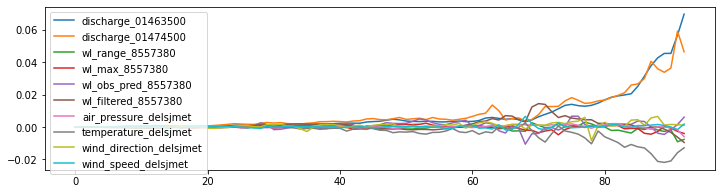

In [16]:
# plot attribution around the extreme space-time
plt.figure(figsize=(12,3))
for i in range(10):
    plt.plot(EG_vals[0,:93, i].detach(), label = inputs[i])
plt.legend(loc='upper left');

# print aggregate measures of attribution
for i in range(10):
    print(inputs[i], '\n\t', np.sum(np.abs(EG_vals[:,:,i].detach().numpy()), axis = 0)[i])

discharge_01463500 
	 8.323439e-05
discharge_01474500 
	 8.859861e-05
wl_range_8557380 
	 4.1379503e-06
wl_max_8557380 
	 4.207708e-05
wl_obs_pred_8557380 
	 0.00011792463
wl_filtered_8557380 
	 0.00019193017
air_pressure_delsjmet 
	 0.00012234735
temperature_delsjmet 
	 2.6683878e-05
wind_direction_delsjmet 
	 4.2133775e-06
wind_speed_delsjmet 
	 5.104338e-05


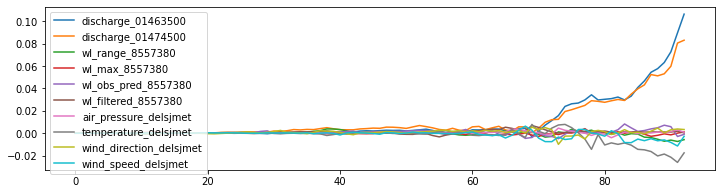

In [17]:
### EGS for optimal inputx
EG_vals = expected_gradients(optimal_input[3].reshape(1,180,10), 
                             y[3].reshape(1,180,1),
                             x, 
                             model=model,
                             n_samples=200, 
                             temporal_focus=93)

plt.figure(figsize=(12,3))
for i in range(10):
    plt.plot(EG_vals[0,:93, i].detach(), label = inputs[i])
plt.legend(loc='upper left');

# print aggregate measures of attribution
for i in range(10):
    print(inputs[i], '\n\t', np.sum(np.abs(EG_vals[:,:,i].detach().numpy()), axis = 0)[i])

In [18]:
optimal_input.shape

torch.Size([30, 180, 10])

In [19]:
sf_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
sf_sd = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data
salt_fronts = (prepped_model_io_data['trainval_targets']*sf_sd) + sf_mean

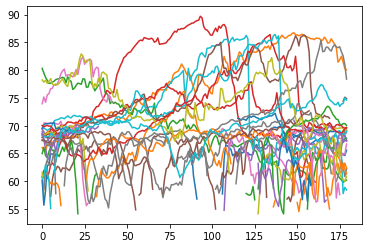

In [20]:
for i in range(len(salt_fronts)):
    plt.plot(salt_fronts[i])
    
plt.pause(0.0001)
plt.figure(figsize=(9,2))
plt.plot(

In [153]:
prepped_model_io_data.keys()

dict_keys(['train_features', 'train_targets', 'val_features', 'val_targets', 'trainval_features', 'trainval_targets', 'test_features', 'test_targets', 'means_stds'])

In [167]:
np.where(salt_fronts > 80)[0]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15

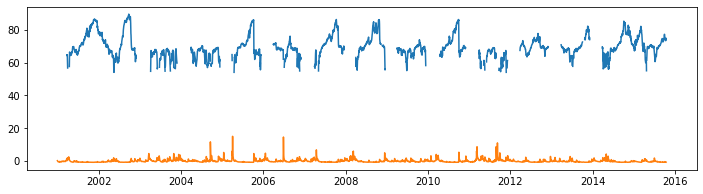

In [28]:
dates = pd.date_range(start = config['train_start_date'], periods = x.shape[0]*x.shape[1], freq = 'D')
plt.figure(figsize=(12,3))
plt.plot(dates, salt_fronts.flatten())
plt.plot(dates, x[:,:,0].flatten())

#### Ok, try to simulate an increasing salt front and see what happens

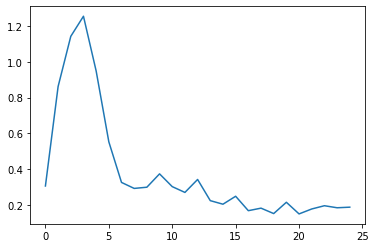

In [197]:
y_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
y_std = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data
y_inflated = ((y.clone()*y_std)+y_mean)*1.01
y_inflated = (y_inflated-y_mean)/y_std



optimal_input = x.clone()
optimal_input.requires_grad = True
optimizer = torch.optim.Adam([optimal_input], lr = 0.1)
loss_fn = rmse_masked
loss_ls = []
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data
tq_mean_s = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01474500'].data
tq_sd_s = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01474500'].data
m = torch.nn.ReLU()

for i in range(25):
    
    optimal_output,_ = model(optimal_input)
    loss = (loss_fn(y_inflated[1:4], optimal_output[1:4]) + 
            #Penalize discharge for going below zero
            .5*torch.mean(torch.sqrt(m(torch.negative((optimal_input[1:4,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean))))) +
            .5*torch.mean(torch.sqrt(m(torch.negative((optimal_input[1:4,:,1]*torch.tensor(tq_sd_s))+torch.tensor(tq_mean_s))))))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_ls.append(loss.item())
    
plt.plot(loss_ls)

In [187]:
dates = np.array(dates).reshape(y.shape)

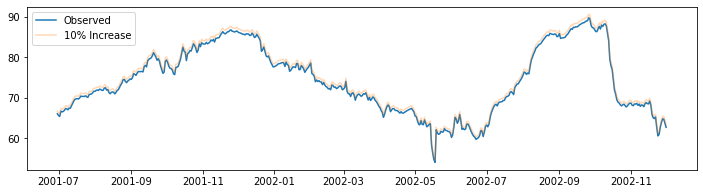

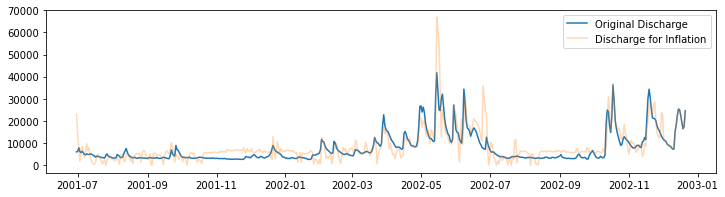

In [198]:
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),(y[1:4].flatten().detach().numpy()*y_std)+y_mean,label="Observed")
plt.plot(dates[1:4].flatten(),(y_inflated[1:4].flatten().detach().numpy()*y_std)+y_mean,label='10% Increase',alpha=.3)
plt.legend()
plt.pause(.0001)
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),((x[1:4,:,0]*tq_sd)+tq_mean).flatten().detach().numpy(),label='Original Discharge')
plt.plot(dates[1:4].flatten(),((optimal_input[1:4,:,0].detach().numpy()*tq_sd)+tq_mean).flatten(),label='Discharge for Inflation',alpha=.3)
plt.legend()           

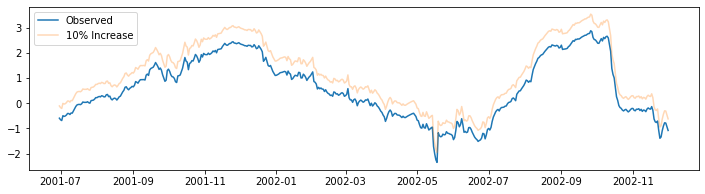

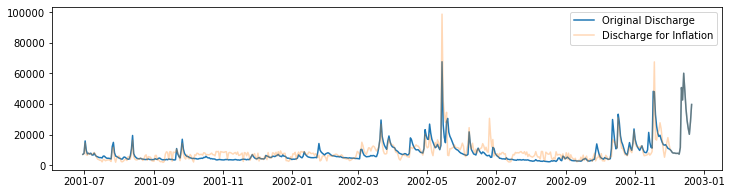

In [190]:
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),y[1:4].flatten().detach().numpy(),label="Observed")
plt.plot(dates[1:4].flatten(),y_inflated[1:4].flatten().detach().numpy(),label='10% Increase',alpha=.3)
plt.legend()
plt.pause(.0001)
plt.figure(figsize=(12,3))
plt.plot(dates[1:4].flatten(),((x[1:4,:,1]*tq_sd)+tq_mean).flatten().detach().numpy(),label='Original Discharge')
plt.plot(dates[1:4].flatten(),((optimal_input[1:4,:,1].detach().numpy()*tq_sd)+tq_mean).flatten(),label='Discharge for Inflation',alpha=.3)
plt.legend()        

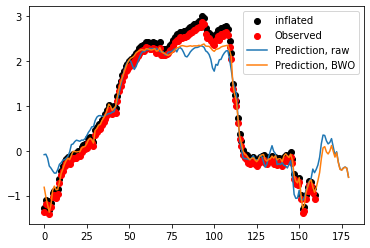

In [200]:
plt.scatter(range(180), y_inflated[3].detach(), color = 'black', label = 'inflated')
plt.scatter(range(180), y[3].detach(), color = 'red', label = 'Observed')
natural_out, _ = model(x)
plt.plot(natural_out[3].detach(), label = 'Prediction, raw')

optimal_out, _ = model(optimal_input)
plt.plot(optimal_output[3].detach(), label = 'Prediction, BWO')
plt.legend(loc = 'upper right');

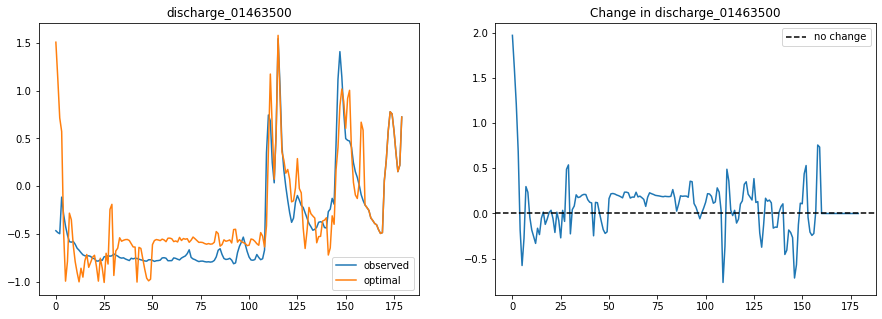

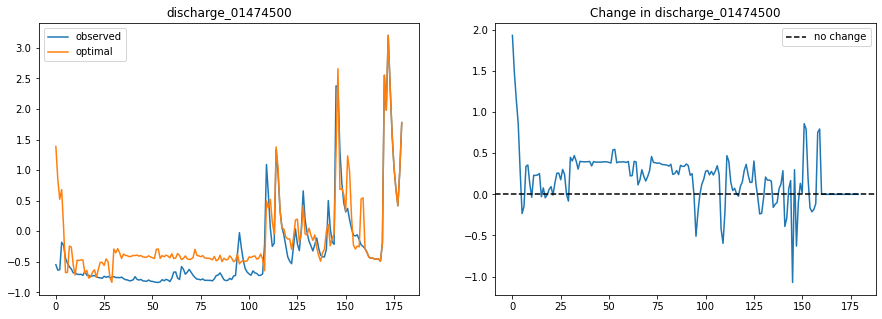

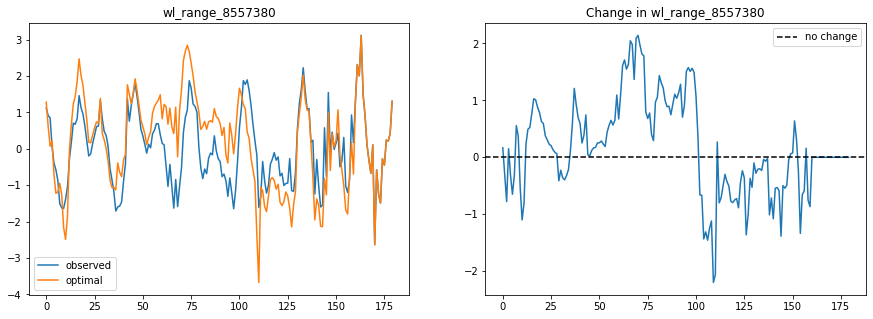

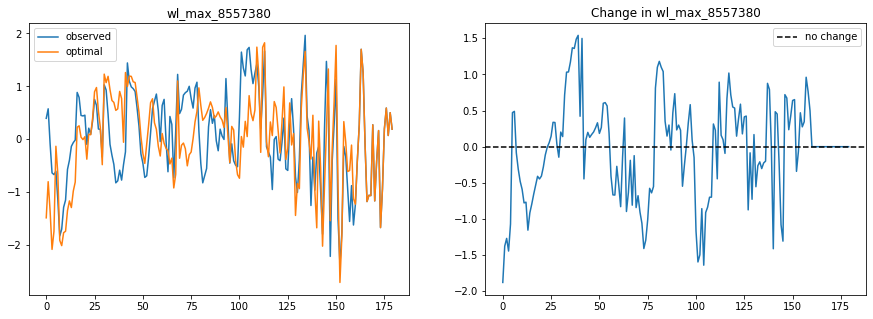

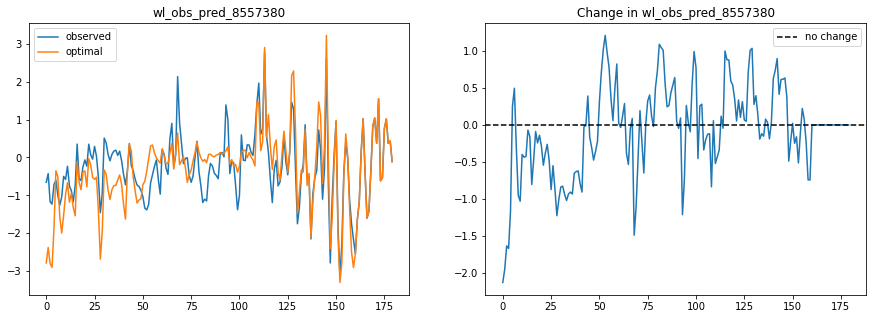

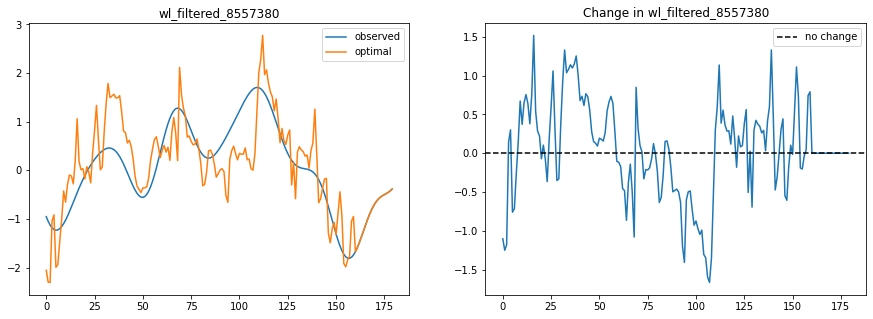

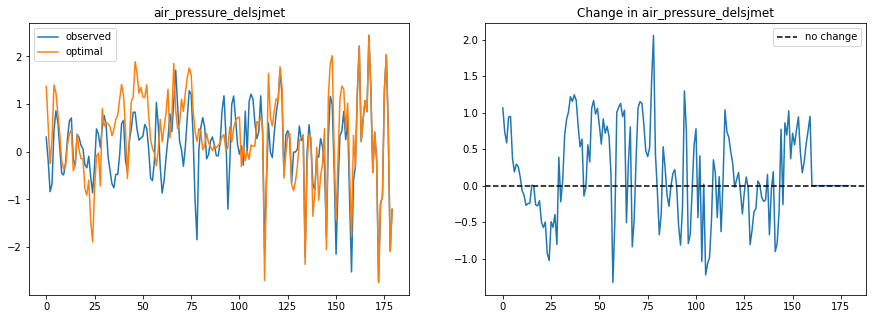

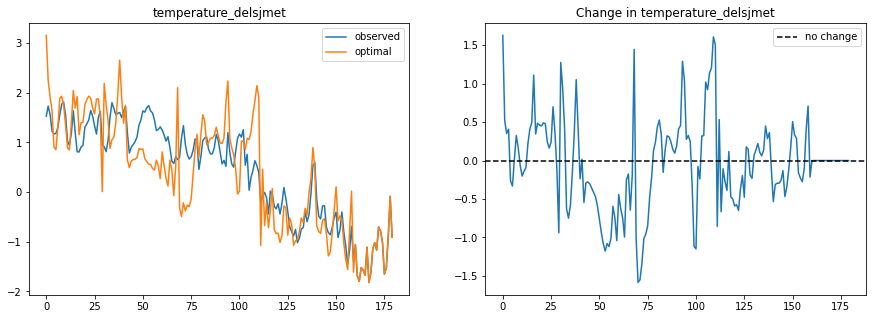

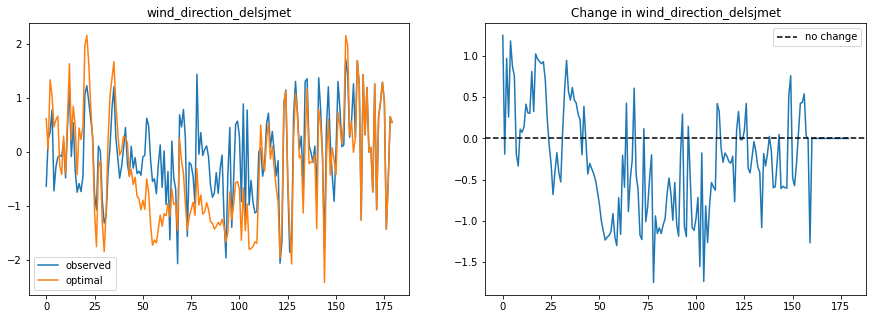

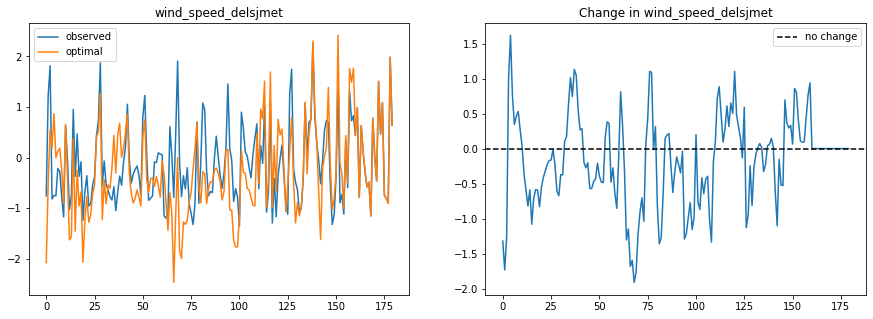

In [201]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].plot(range(180), x[3, :, i].detach(), label = 'observed')
    ax[0].plot(range(180), optimal_input[3, :, i].detach(), label = 'optimal')
    ax[0].legend()
    ax[0].set_title(inputs[i])
    
    ax[1].plot(range(180),
               optimal_input[3, :, i].detach() - x[3, :, i].detach())
    ax[1].axhline(0, color = 'black', linestyle = '--', label = 'no change')
    ax[1].legend()
    ax[1].set_title('Change in ' + inputs[i])
    
    plt.pause(0.00001)

## Wrap it into a function and gradually increase 

In [320]:
y_mean = prepped_model_io_data['means_stds']['y_mean_trnval']['saltfront_daily'].data
y_std = prepped_model_io_data['means_stds']['y_std_trnval']['saltfront_daily'].data
tq_mean = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01463500'].data
tq_sd = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01463500'].data
tq_mean_s = prepped_model_io_data['means_stds']['x_mean_trnval']['discharge_01474500'].data
tq_sd_s = prepped_model_io_data['means_stds']['x_std_trnval']['discharge_01474500'].data


def adjust_front(x_set, y_set, target_series, start, stop, step):
    loss_fn = rmse_masked
    inputs_out = []
    output_out = []
    y_out= []
    for i in np.arange(start,stop,step):
        y_inflated = ((y_set.clone()*y_std)+y_mean)*i
        y_inflated = (y_inflated-y_mean)/y_std

        optimal_input = x_set.clone()
        optimal_input.requires_grad = True
        optimizer = torch.optim.Adam([optimal_input], lr = 0.01)
        
        m = torch.nn.ReLU()
        loss_ls=[]
        
        for i in range(50):

            optimal_output,_ = model(optimal_input)
            loss = (loss_fn(y_inflated[target_series], optimal_output[target_series]) + 
                    #Penalize discharge for going below zero
                    .001*torch.mean(torch.sqrt(m(torch.negative((optimal_input[target_series,:,0]*torch.tensor(tq_sd))+torch.tensor(tq_mean))))) +
                    .001*torch.mean(torch.sqrt(m(torch.negative((optimal_input[target_series,:,1]*torch.tensor(tq_sd_s))+torch.tensor(tq_mean_s))))))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_ls.append(loss.item())
        
        plt.plot(loss_ls)
        opt_out,_=model(optimal_input)
        y_out.append(y_inflated.detach().numpy())
        output_out.append(opt_out.detach().numpy())
        inputs_out.append(optimal_input.detach().numpy())
    return {'optimal_inputs':np.array(inputs_out), 'optimal_outputs':np.array(output_out), 'y_out':np.array(y_out)}


((6, 30, 180, 10), (6, 30, 180, 1))

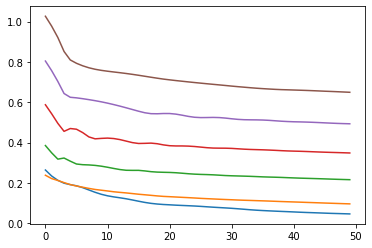

In [321]:
fronts = adjust_front(x, y, slice(1,2),1,1.1,0.02)
fronts['optimal_inputs'].shape, fronts['optimal_outputs'].shape

In [322]:
opt_inputs = fronts['optimal_inputs']
ops_outputs = fronts['optimal_outputs']
inputs_scaled = np.ones_like(opt_inputs)
for i in range(10):
    inputs_scaled[:,:,:,i] = ((opt_inputs[:,:,:,i]*prepped_model_io_data['means_stds']['x_std_trnval'][config['inputs'][i]].data) +
                              prepped_model_io_data['means_stds']['x_mean_trnval'][config['inputs'][i]].data)
outputs_scaled = (ops_outputs*y_std)+y_mean
y_out_scaled = (fronts['y_out']*y_std)+y_mean

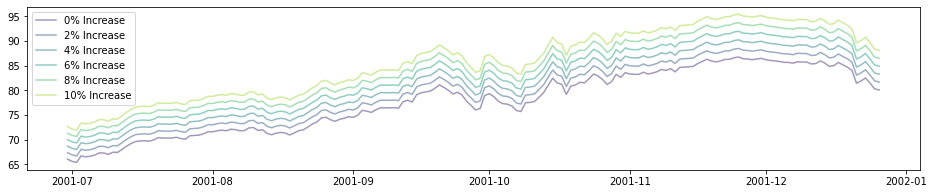

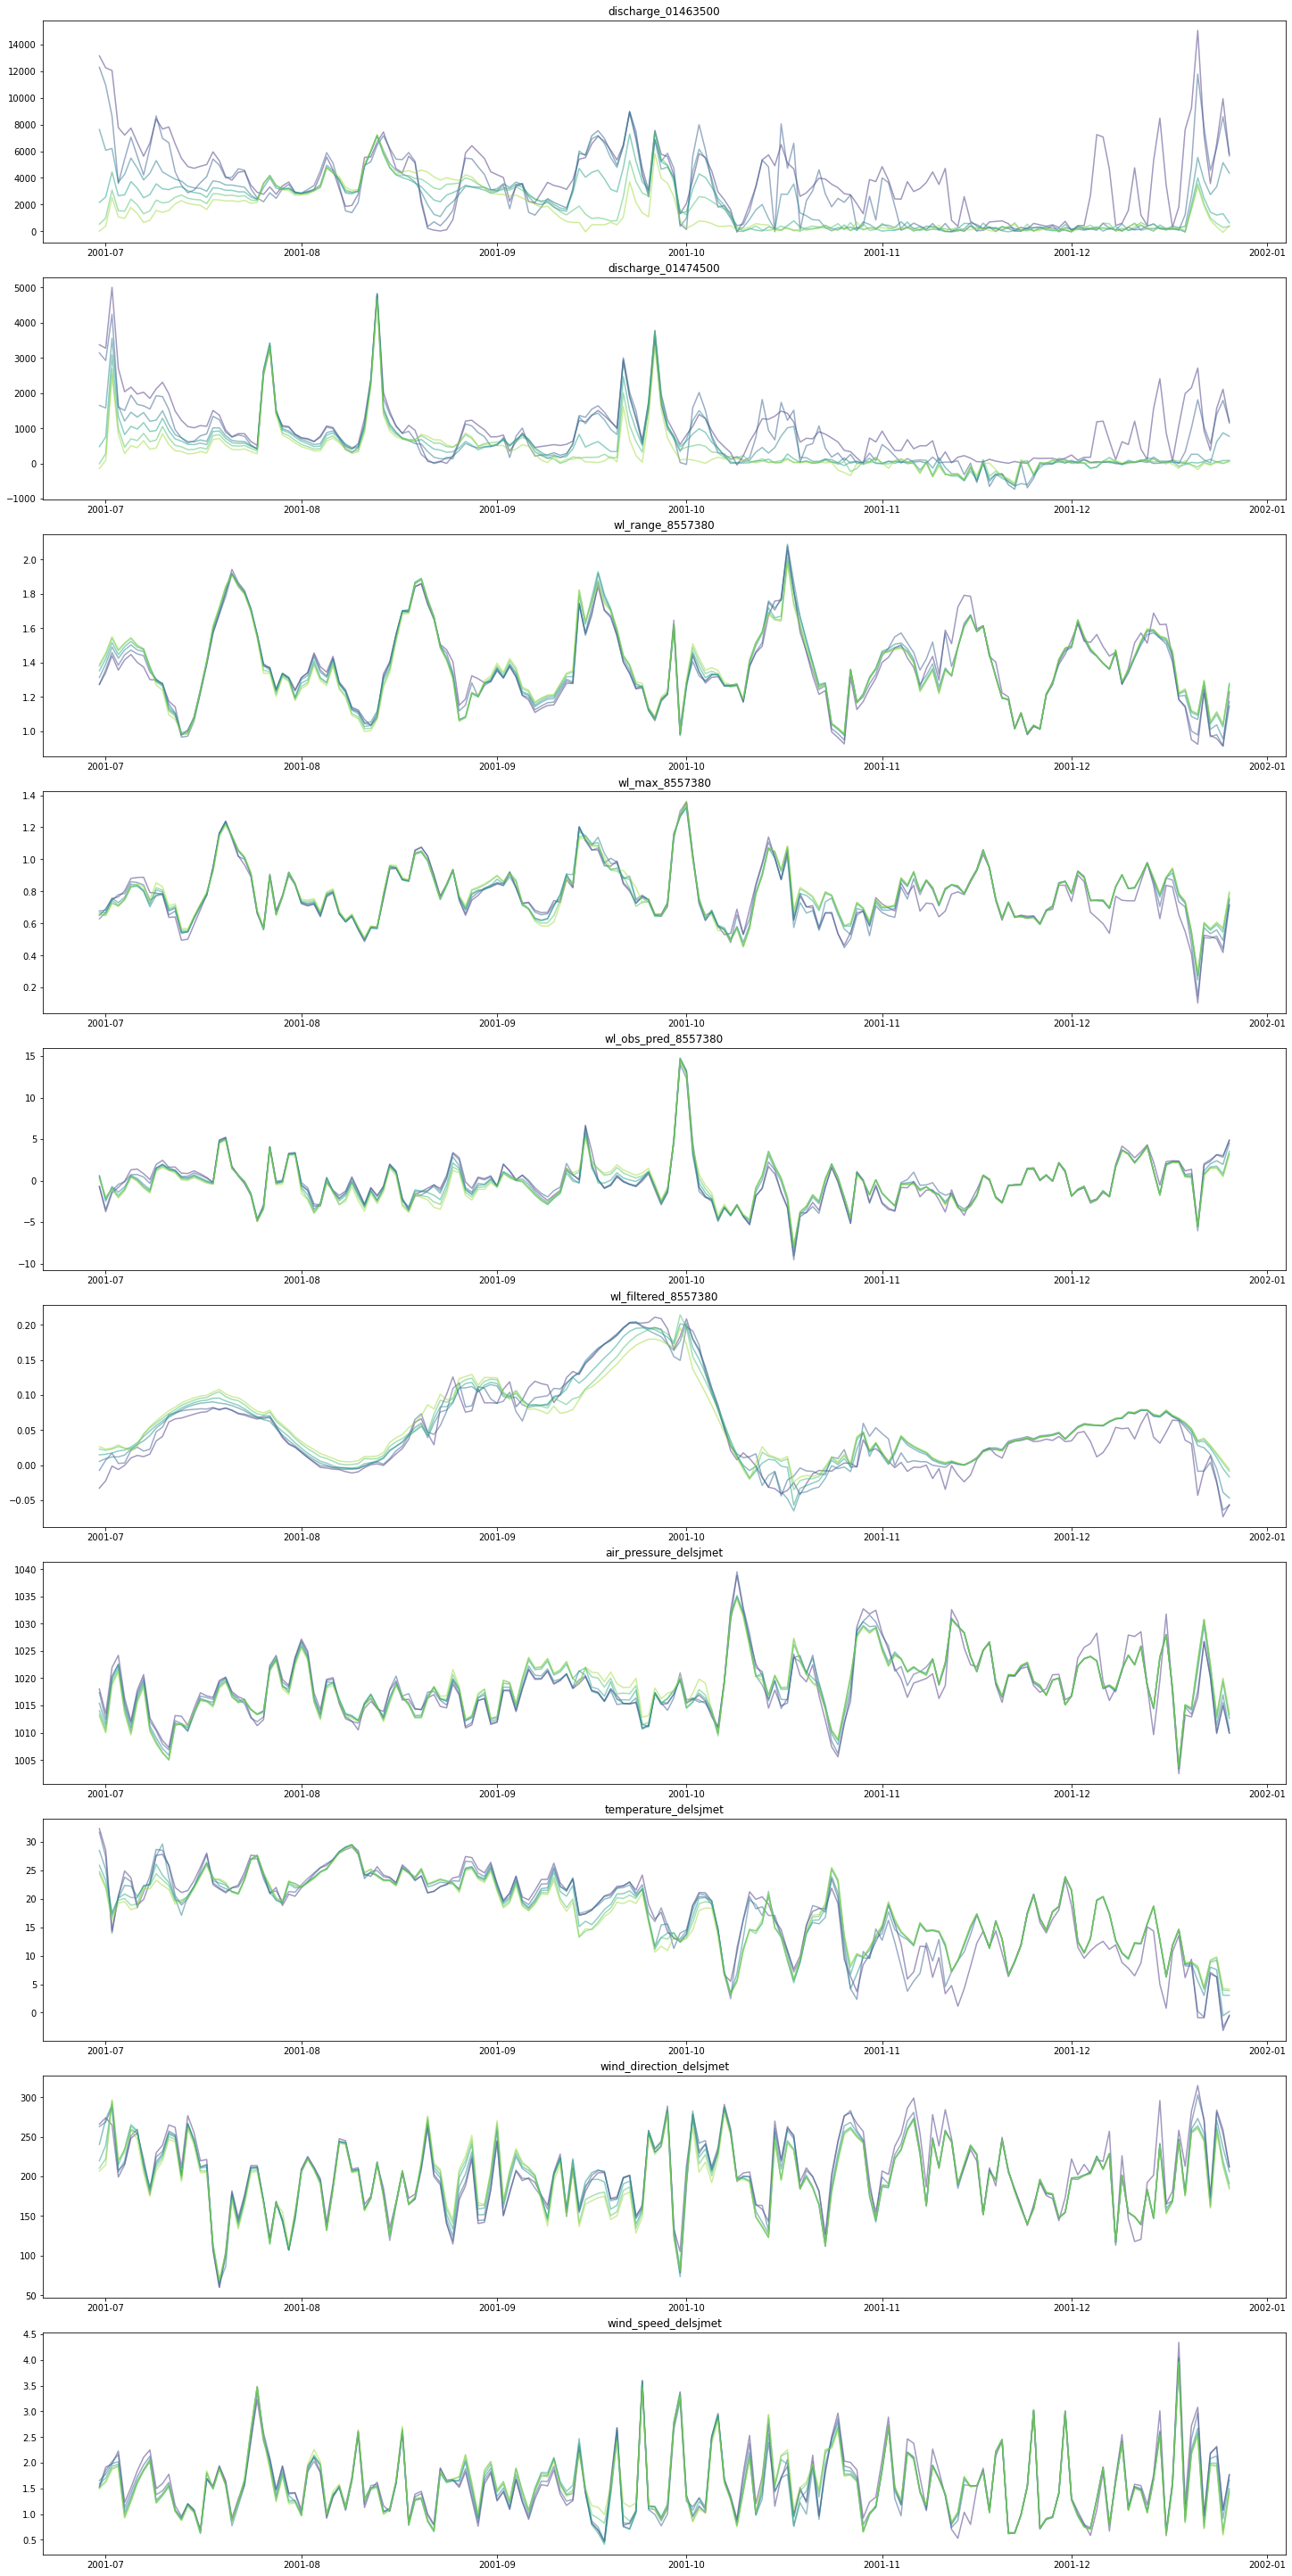

In [323]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))
segs = slice(1,2)

plt.figure(figsize=(16,3))
for i in range(len(opt_inputs)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i,segs].flatten(),color=pal[i],label=f'{2*i}% Increase',alpha=.5)
    plt.legend()

plt.pause(0.001)


fig, ax = plt.subplots(10,1,figsize=(20,40),constrained_layout=True)
for i in range(10):
    ax[i].set_title(config['inputs'][i])
    for j in range(len(inputs_scaled)):
        ax[i].plot(dates[segs].flatten(),inputs_scaled[j,segs,:,i].flatten(),label = f'{j}% Inflation',color=pal[j], alpha=.5)
        
                


In [324]:
np.where(y>

<module 'numpy' from '/Users/stopp/opt/anaconda3/envs/torch_xai/lib/python3.9/site-packages/numpy/__init__.py'>

(array([  6.,   8.,   7.,  20.,  20.,  23.,  27.,  41.,  39.,  48.,  69.,
         61.,  87.,  79., 113., 135., 133., 177., 209., 285., 334., 252.,
        195., 172., 153.,  92.,  78.,  92.,  70.,  39.,  43.,  56.,  45.,
         56.,  50.,  57.,  40.,  20.,  30.,  26.,  25.,  25.,  41.,  40.,
         44.,  24.,  11.,   9.,   5.,   2.]),
 array([54.111   , 54.82278 , 55.53456 , 56.24634 , 56.95812 , 57.6699  ,
        58.38168 , 59.09346 , 59.80524 , 60.51702 , 61.228798, 61.94058 ,
        62.65236 , 63.36414 , 64.07592 , 64.7877  , 65.49948 , 66.21126 ,
        66.92304 , 67.63482 , 68.346596, 69.05838 , 69.77016 , 70.48194 ,
        71.19372 , 71.9055  , 72.61728 , 73.329056, 74.04084 , 74.75262 ,
        75.4644  , 76.17618 , 76.887955, 77.59974 , 78.311516, 79.0233  ,
        79.73508 , 80.44686 , 81.15864 , 81.870415, 82.5822  , 83.293976,
        84.00576 , 84.71754 , 85.42931 , 86.1411  , 86.852875, 87.56466 ,
        88.276436, 88.98822 , 89.7     ], dtype=float32),
 <BarCon

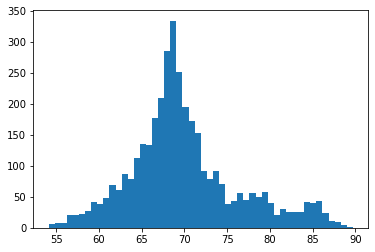

In [338]:
plt.hist(((y.detach().numpy()*y_std)+y_mean).flatten(), bins=50)
#(y.detach().numpy()*y_std)+y_mean

In [331]:
y.flatten()

tensor([   nan,    nan,    nan,  ..., 0.5710, 0.7205, 0.6634])

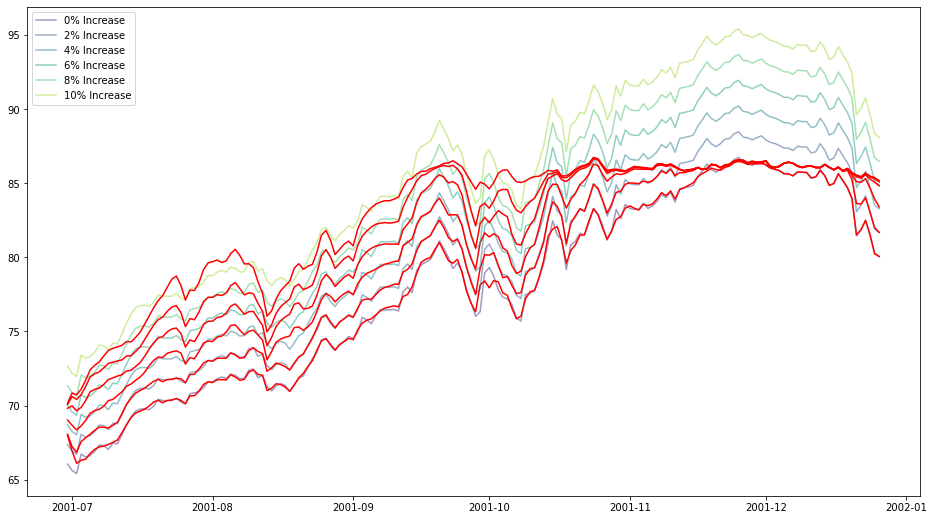

In [325]:
pal = list(sns.color_palette("viridis",len(opt_inputs)))
segs = slice(1,2)

plt.figure(figsize=(16,9))
for i in range(len(y_out_scaled)):
    plt.plot(dates[segs].flatten(),y_out_scaled[i,segs].flatten(),color=pal[i],label=f'{2*i}% Increase',alpha=.5)
    plt.plot(dates[segs].flatten(), outputs_scaled[i,segs].flatten(),color='red')
    plt.legend()